# Exploring neighborhoods and venues in Atlanta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing Folium - Python library for visualizing maps

In [3]:
pip install folium

### Importing all the needed libraries

In [4]:
import pandas as pd
import folium
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
import requests
from collections import Counter

### Importing Atlanta neighborhood dataset

The Atlanta neighborhood dataset consists of 3 columns:
- **Neighborhood**: Lists all the neighborhoods in the city
- **Population**: Lists the population in each of the neighborhoods
- **NPU**: This is known as the *Neighborhood Planning Unit*. There are a total of 25 NPUs in Atlanta, similar to boroughs in the city of New York. Each NPU consists of several neighborhoods

In [5]:
df = pd.read_csv('/content/drive/MyDrive/atlanta_neighborhoods.csv')
df.head()

Neighborhood  Population (2010) NPU
0   Adair Park               1331   V
1   Adams Park               1763   R
2   Adamsville               2403   H
3  Almond Park               1020   G
4  Ansley Park               2277   E

**Note: Some initial cleaning had to be done in Excel in order to remove non-ASCII characters which threw encoding errors while importing the CSV dataset. Thankfully, there were only 2 such instances.**

Now that we have our initial neighborhoods dataset, we can quickly look at a summary of the dataset and also make sure that we have all the neighborhoods

In [6]:
#Overview of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Neighborhood       161 non-null    object
 1   Population (2010)  161 non-null    int64 
 2   NPU                161 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.9+ KB


We can see that the dataframe consists of 161 observations each representing a unique neighborhood of Atlanta. The number of columns is also specified (3). Also, the *info()* function reports that there are no *null* instances, which is good. 

In [7]:
#Data types of each variable
print (df.dtypes)

#Summary statistics for each numerical variable
df.describe(include="all")

Neighborhood         object
Population (2010)     int64
NPU                  object
dtype: object


Neighborhood  Population (2010)  NPU
count                     161         161.000000  161
unique                    161                NaN   25
top     Whittier Mill Village                NaN    B
freq                        1                NaN   15
mean                      NaN        2381.844720  NaN
std                       NaN        2287.806454  NaN
min                       NaN         501.000000  NaN
25%                       NaN         937.000000  NaN
50%                       NaN        1738.000000  NaN
75%                       NaN        2785.000000  NaN
max                       NaN       16569.000000  NaN

Above, we first see that the *Population (2010)* parameter is the only numerical variable while the other two are of *object/string* type

Then we use the *describe()* function to print summary statistics for the numerical variable. From these stats, we can see that the mean population of a neighborhood is 2381.84472 and the maximum population in a neighborhood is 16569.

Another thing to take note of is that NPU *B* contains the most number of neighborhoods with a total of 15. We can also see that there are in fact 25 unique NPUs. 

Let's quickly change the name of the population column to something more simple

In [8]:
#Renaming the population column
df = df.rename(columns={"Population (2010)":"Population"})
df.head()

Neighborhood  Population NPU
0   Adair Park        1331   V
1   Adams Park        1763   R
2   Adamsville        2403   H
3  Almond Park        1020   G
4  Ansley Park        2277   E

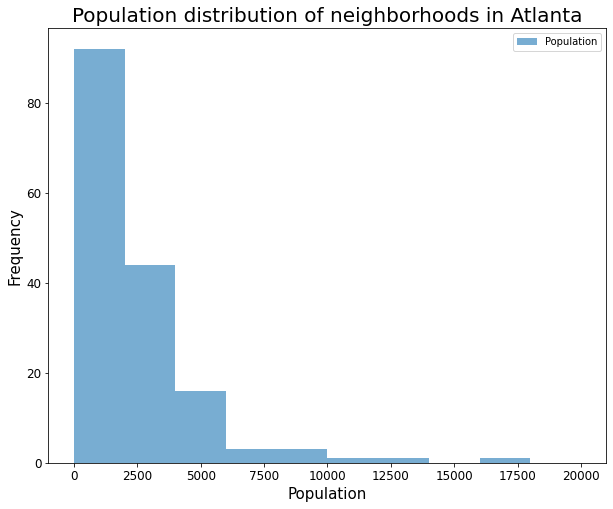

In [9]:
#Looking at the population distribution in each neighborhood
df.plot(kind='hist',alpha=0.6,figsize=(10,8),range=(0,20000),bins=10)
plt.xlabel("Population",size=15)
plt.ylabel("Frequency",size=15)
plt.title("Population distribution of neighborhoods in Atlanta",size=20)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

From the distribution above, it looks like most of the neighborhoods have a population of under 2000. In fact, the distribution is highly **right skewed**. From the summary stats table we saw earlier, the **upper quartile for population is 2785** which means that 75% of the neighborhoods have a population under 2785. This number falls on the extreme left of the histogram above which is one way to get a measure of the skewness. For a perfectly normal distribution, the median would lie somewhere around the center of the graph.

### Fetching latitude and longitude information for each neighborhood

Installing *geopy* library

In [10]:
from geopy.geocoders import Nominatim

Let's try to fetch the coordinates for one of the neighborhoods - Adair Park

In [11]:
address = 'Whittier Mill Village Atlanta'

geolocator = Nominatim(user_agent="atl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ',address,' are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  Whittier Mill Village Atlanta  are 36.15673, -95.9559448.


The above coordinates match the coordinates shown on Google so we can potentially extract the coordinates in similar fashion for all of the neighborhoods. 

We can now loop through the neighborhoods and run the geolocator object to extract all the coordinates and include them in our dataframe. 

In [12]:
#Finding the coordinates for each neighborhood
lat = []
long = []
count = 0

for i in df["Neighborhood"]:
    location = geolocator.geocode(i.strip()+" Atlanta",timeout=10)
    try:
        latitude = location.latitude
        longitude = location.longitude
        lat.append(latitude)
        long.append(longitude)
        count = count + 1
        if count == 20:
          print ()
          print ("And so on....")
        elif count > 20: 
          pass
        else:
          print (i,latitude,longitude)
    except:
        latitude = 998
        longitude = 999
        lat.append(latitude)
        long.append(longitude)
        count = count + 1
        if count == 20:
          print ()
          print ("And so on....")
        elif count > 21: 
          pass
        else:
          print (i,latitude,longitude)

Adair Park 33.72467075 -84.41115399240549
Adams Park 33.7120523 -84.4568734
Adamsville 33.7592737 -84.505209
Almond Park 998 999
Ansley Park 33.7945497 -84.3763154
Ardmore 33.8062822 -84.4000278
Argonne Forest 33.835784 -84.402586
Arlington Estates 998 999
Ashview Heights 33.756067 -84.517118
Atlanta University Center 33.749524 -84.4129421
Atlantic Station 33.7900612 -84.398518
Audubon Forest 33.72596 -84.471496
Baker Hills 33.769502 -84.464045
Bankhead 33.7718772 -84.4255518
Beecher Hills 33.7231742 -84.4634111
Ben Hill 33.6906644 -84.5113194
Ben Hill Terrace 33.6906644 -84.5113194
Benteen Park 33.7151072 -84.3635367
Berkeley Park 33.801055649999995 -84.40949205020351

And so on....


**Note: While fetching the coordinates using *geolocator.geocode()* the *timeout* value needed to be set to 10 to prevent a *Service timeout* error.**

Adding the latitudes and longitudes to the dataset

In [13]:
df["Latitude"] = lat
df["Longitude"] = long
df.head()

Neighborhood  Population NPU    Latitude   Longitude
0   Adair Park        1331   V   33.724671  -84.411154
1   Adams Park        1763   R   33.712052  -84.456873
2   Adamsville        2403   H   33.759274  -84.505209
3  Almond Park        1020   G  998.000000  999.000000
4  Ansley Park        2277   E   33.794550  -84.376315

You may have noticed that the *geolocator* was not able to fetch some of the coordinates. So we had a error catcher in the for loop which assigned a *(998,999)* coordinates to those. Let's see how many such instances exist in our dataset.

In [14]:
#Filtering the instances where the latitude and longitude are both 0
df_zero = df[(df["Latitude"]==998)&(df["Longitude"]==999)]
print ("Number of neighborhoods with missing coordinates: ",len(df_zero))
df_zero

Number of neighborhoods with missing coordinates:  27


Neighborhood  Population NPU  Latitude  Longitude
3                         Almond Park        1020   G     998.0      999.0
7                   Arlington Estates         776   P     998.0      999.0
19                     Betmar LaVilla         578   Y     998.0      999.0
38                Cascade Avenue/Road        2416   S     998.0      999.0
45             Custer/McDonough/Guice        1257   W     998.0      999.0
54                 East Chastain Park        2065   B     998.0      999.0
59                      Fairburn Mays        3144   H     998.0      999.0
60                      Fairway Acres         513   P     998.0      999.0
65                   Glenrose Heights        4071   Z     998.0      999.0
70                    Harland Terrace        2138   I     998.0      999.0
71                      Harris Chiles         765   T     998.0      999.0
81         Knight Park/Howell Station        2545   K     998.0      999.0
92             Marietta Street Artery         745   E     998.0      999.0
96                    Midwest Cascade        1786   Q     998.0      999.0
97                     Monroe Heights         903   G     998.0      999.0
100               Mt. Paran/Northside        1568   A     998.0      999.0
114                Penelope Neighbors         559   J     998.0      999.0
118                  Piedmont Heights        2323   F     998.0      999.0
122                       Pamond Park         556   R     998.0      999.0
123                   Poncey-Highland        2133   N     998.0      999.0
134                 South Tuxedo Park        1085   B     998.0      999.0
138            Swallow Circle/Baywood         577   Z     998.0      999.0
145            The Villages at Carver        1039   Y     998.0      999.0
146  The Villages at Castleberry Hill         864   T     998.0      999.0
147         The Villages at East Lake        1460   O     998.0      999.0
154        West Paces Ferry/Northside        1218   A     998.0      999.0
159               Wilson Mill Meadows        1096   H     998.0      999.0

Looks like we have 38 instances where the geolocator was not able to retrieve the exact coordinates. So to reduce time and effort, we can simply look up these 38 coordinates on Google and replace them in our dataset. It may be slightly painful to do it manually but this may eventually save us a lot of time. 

Before we do that, let's do an initial visualization of the coordinates using the *Folium* map vizualization library. 

In [15]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=4)

# add markers to map of Toronto neighborhoods
for lat, lng, npu, neighborhood in zip(df['Latitude'], df['Longitude'], df['NPU'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

On the map above, we can see that 5 coordinates have actually been misplaced as they seem to be far away from Atlanta or Georgia. For those points, we can manually look up the coordinates as well. These neighborhoods appear to be:

- Whittier Mill Village
- South Atlanta
- Kings Forest
- Kingswood

Below we manually look up the coordinates on Google and store them in a data structure that is simple to work with. 

In [16]:
#Manual coordinates from Google
almond = (33.7815,-84.4671)
arlington = (33.6915,-84.5419)
#baker = (33.7603,-84.5209)
betmar = (33.7068,-84.4009)
#capitol = (33.7453,-84.3841)
#carver_hills = (33.7993,-84.4606)
cascade_avenue = (33.749,-84.388)
#chosewood = (33.7204,-84.3765)
custer = (33.7153,-84.3568)
chastain = (33.8682,-84.3844)
#english = (33.7678,-84.4094)
fairburn = (33.5671,-84.581)
fairway = (33.6858,-84.5393)
glenrose = (33.675,-84.391)
harland = (33.7499,-84.4763)
chiles = (33.7447,-84.4212)
knight = (33.7794,-84.4199)
#lindridge = (33.8155,-84.3568)
marietta_artery = (33.7723,-84.4022)
cascade = (33.7286,-84.5301)
monroe = (33.7954,-84.4882)
mount_paran = (33.8687,-84.4251)
#ward = (33.7661,-84.3726)
#alliance = (33.823,-84.3989)
#heights_east = (33.8264,-84.3818)
#heights_west = (33.8352,-84.3923)
penelope = (33.7517,-84.4527)
piedmont = (33.8064,-84.3713)
pamond = (998,999)
poncey = (33.7695,-84.3555)
#south_river = (33.6625,-84.3595)
#scotts = (33.8032,-84.4691)
tuxedo = (33.8461,-84.3871)
baywood = (33.6929,-84.3844)
carver = (33.7126,-84.3897)
castleberry = (33.7447,-84.4074)
east_lake = (33.7407,-84.313)
ferry = (33.8462,-84.4199)
meadows = (33.7519,-84.5209)

#Need to add the four remaining neighborhoods that were wrongly located
whittier = (33.8087,-84.4842)
south_atlanta = (33.7124,-84.3844)
kings = (36.097,-79.7386)
kingswood = (33.8556,-84.4133)


#Retrieving indexes of the missing neighborhoods
index = list(df_zero.index)

#combining all the missing coordinates tuples into a list for easier computation
'''
missing_neighborhoods = [almond,arlington,baker,betmar,capitol,carver_hills,cascade_avenue,chosewood,custer,chastain,english,fairburn,fairway,glenrose,harland,
                        chiles,knight,lindridge,marietta_artery,cascade,monroe,mount_paran,ward,alliance,heights_east,heights_west,
                         penelope,pamond,poncey,south_river,scotts,tuxedo,baywood,carver,castleberry,east_lake,ferry,meadows,
                        whittier,south_atlanta,piedmont,kings,kingswood]
'''
missing_neighborhoods = [almond,arlington,betmar,cascade_avenue,custer,chastain,fairburn,fairway,glenrose,harland,
                        chiles,knight,marietta_artery,cascade,monroe,mount_paran,
                         penelope,piedmont,pamond,poncey,tuxedo,baywood,carver,castleberry,east_lake,ferry,meadows,
                        whittier,south_atlanta,kings,kingswood]
#Unzipping the list of tuples to separate the latitudes and longitudes into separate lists/tuples
missing_neighborhoods = list(zip(*missing_neighborhoods))

That took a bit of an effort but we finally have the missing coordinates into a structure that we can manipulate and get the data we want out of. With some manual work, the latitudes and longitudes are now split into separate tuples which are contained in a single list. This kind of structure will allow us to easily loop through it and extract the information that we need. 

Next we need to find the indices of the 5 outlying neighborhoods and add them to the *index* variable

In [17]:
for i in range(len(index)):
    print (i)
    print (missing_neighborhoods[0][i])
    df.iloc[index[i],:] = df.iloc[index[i],:].replace(998,missing_neighborhoods[0][i])
    df.iloc[index[i],:] = df.iloc[index[i],:].replace(999,missing_neighborhoods[1][i])

0
33.7815
1
33.6915
2
33.7068
3
33.749
4
33.7153
5
33.8682
6
33.5671
7
33.6858
8
33.675
9
33.7499
10
33.7447
11
33.7794
12
33.7723
13
33.7286
14
33.7954
15
33.8687
16
33.7517
17
33.8064
18
998
19
33.7695
20
33.8461
21
33.6929
22
33.7126
23
33.7447
24
33.7407
25
33.8462
26
33.7519


In the above cell, we have looped through the indices containing the missing coordinates and replaced the *998* and *999* dummy values with the actual coordinates contained in the *missing_neighborhood* variable. 

Let's check to confirm that the substitions were effective

In [18]:
#Looping through the 25 instances in question to check if the coordinates replacement took effect
for i in range(len(index))[:4]:
    print (df.iloc[index[i],:])
    print ("")

Neighborhood    Almond Park
Population             1020
NPU                       G
Latitude            33.7815
Longitude          -84.4671
Name: 3, dtype: object

Neighborhood    Arlington Estates
Population                    776
NPU                             P
Latitude                  33.6915
Longitude                -84.5419
Name: 7, dtype: object

Neighborhood    Betmar LaVilla
Population                 578
NPU                          Y
Latitude               33.7068
Longitude             -84.4009
Name: 19, dtype: object

Neighborhood    Cascade Avenue/Road
Population                     2416
NPU                               S
Latitude                     33.749
Longitude                   -84.388
Name: 38, dtype: object



Looks like the coordinates substitutions worked. Next, let's add in those four outlying coordinates we saw on the map

In [19]:
#Finding the indices of the 4 outlying coordinates from the earlier map
whittier_index = df[df["Neighborhood"]=="Whittier Mill Village"].index[0]
south_atlanta_index = df[df["Neighborhood"]=="South Atlanta"].index[0]
kings_index = df[df["Neighborhood"]=="Kings Forest"].index[0]
kingswood_index = df[df["Neighborhood"]=="Kingswood"].index[0]

#Checking the data for the 4 outlying locations
print (df.iloc[whittier_index,:])
print (df.iloc[south_atlanta_index,:])
print (df.iloc[kings_index,:])
print (df.iloc[kingswood_index,:])

Neighborhood    Whittier Mill Village
Population                        617
NPU                                 D
Latitude                      36.1567
Longitude                    -95.9559
Name: 157, dtype: object
Neighborhood    South Atlanta
Population               1738
NPU                         Y
Latitude              45.0048
Longitude             -84.152
Name: 132, dtype: object
Neighborhood    Kings Forest
Population              1674
NPU                        P
Latitude             45.1514
Longitude           -64.5041
Name: 78, dtype: object
Neighborhood    Kingswood
Population            660
NPU                     A
Latitude          33.8321
Longitude         -84.405
Name: 79, dtype: object


In [20]:
#First dropping the outliers from the original dataset and then appending the right ones at the end of the dataset
df = df.drop([whittier_index,south_atlanta_index,kings_index,kingswood_index])
df = df.append(pd.DataFrame([["Whittier Mill Village",617,'D',whittier[0],whittier[1]]],columns=df.columns))
df = df.append(pd.DataFrame([["South Atlanta",1738,'Y',south_atlanta[0],south_atlanta[1]]],columns=df.columns))
df = df.append(pd.DataFrame([["Kings Forest",1674,'P',kings[0],kings[1]]],columns=df.columns))
df = df.append(pd.DataFrame([["Kingswood",660,'A',kingswood[0],kingswood[1]]],columns=df.columns))
df

Neighborhood  Population NPU   Latitude  Longitude
0               Adair Park        1331   V  33.724671 -84.411154
1               Adams Park        1763   R  33.712052 -84.456873
2               Adamsville        2403   H  33.759274 -84.505209
3              Almond Park        1020   G  33.781500 -84.467100
4              Ansley Park        2277   E  33.794550 -84.376315
..                     ...         ...  ..        ...        ...
160       Wisteria Gardens         512   H  33.766795 -84.352852
0    Whittier Mill Village         617   D  33.808700 -84.484200
0            South Atlanta        1738   Y  33.712400 -84.384400
0             Kings Forest        1674   P  36.097000 -79.738600
0                Kingswood         660   A  33.855600 -84.413300

[161 rows x 5 columns]

In [21]:
#Re-indexing
df.index = range(df.shape[0])
df

Neighborhood  Population NPU   Latitude  Longitude
0               Adair Park        1331   V  33.724671 -84.411154
1               Adams Park        1763   R  33.712052 -84.456873
2               Adamsville        2403   H  33.759274 -84.505209
3              Almond Park        1020   G  33.781500 -84.467100
4              Ansley Park        2277   E  33.794550 -84.376315
..                     ...         ...  ..        ...        ...
156       Wisteria Gardens         512   H  33.766795 -84.352852
157  Whittier Mill Village         617   D  33.808700 -84.484200
158          South Atlanta        1738   Y  33.712400 -84.384400
159           Kings Forest        1674   P  36.097000 -79.738600
160              Kingswood         660   A  33.855600 -84.413300

[161 rows x 5 columns]

However there is one last thing to rectify, the *Pamond Park* coordinates. Recall that we had once again placed dummy variables *998* and *999* for this neighborhood since the actual coordinates were not found on Google. For simplicity we are going to get rid of this neighborhood instance all together, which should leave us with a total of 160 neighborhoods which actually works as a more user-friendly number. 

In [22]:
#Checking to see where in the dataframe Pamond Park is
pamond_park_index = df[df["Neighborhood"]=="Pamond Park"].index[0]
print ("The Pamond Park neighborhood instance is at index",pamond_park_index)

The Pamond Park neighborhood instance is at index 120


In [23]:
#Dropping the Pamond Park index from the dataset using its index
df = df.drop(pamond_park_index)

In [24]:
#Confirming the shape of the new dataframe
df.shape

(160, 5)

In [25]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 160
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  160 non-null    object 
 1   Population    160 non-null    int64  
 2   NPU           160 non-null    object 
 3   Latitude      160 non-null    float64
 4   Longitude     160 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 7.5+ KB


Neighborhood  Population NPU   Latitude  Longitude
0   Adair Park        1331   V  33.724671 -84.411154
1   Adams Park        1763   R  33.712052 -84.456873
2   Adamsville        2403   H  33.759274 -84.505209
3  Almond Park        1020   G  33.781500 -84.467100
4  Ansley Park        2277   E  33.794550 -84.376315

We now have all the data formatted and cleaned in our dataset. There was also a fair bit of manual and automated data collection involved. 

The dataset now consists of 160 neighborhoods and all their coordinates. The neighborhoods can be visualized again to see if our data cleaning worked.

### Visualizing neighborhoods across Atlanta

In [26]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=4)

# add markers to map of Toronto neighborhoods
for lat, lng, npu, neighborhood in zip(df['Latitude'], df['Longitude'], df['NPU'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

There seems to be only one place that remains misplaced - Kings Forest. As the actual coordinates were not found despite doing a manual Google search, we can exclude this point from our dataset. Considering we have 159 other instances, this should not be a problem. 

In [27]:
kings_index = df[df["Neighborhood"]=="Kings Forest"].index[0]
print ("The index of Kings Forest is",kingswood_index)

The index of Kings Forest is 79


In [28]:
#Dropping the Kingswood instance
df = df.drop(kings_index)

In [29]:
df.shape

(159, 5)

Now that we have confirmed that the shape is as expected let's plot the neighborhoods again with the United States perspective. 

In [30]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=4)

# add markers to map of Toronto neighborhoods
for lat, lng, npu, neighborhood in zip(df['Latitude'], df['Longitude'], df['NPU'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

From the map above, we can see that all the points are now concentrated within the Atlanta area. So now, the same points can be visualized again but from just the Atlanta perspective with a greater zoom. 

In [31]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=10)

# add markers to map of Toronto neighborhoods
for lat, lng, npu, neighborhood in zip(df['Latitude'], df['Longitude'], df['NPU'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

The map shows all 159 neighborhoods scattered densely across Atlanta. For our purposes, we can further narrow this dataset down by filtering out neighborhoods that are outside the I-285 circle. Since our aim is to find areas of maximum traffic, it is more likely that we would find our desirable location within the circle which is more densely populated as can be seen from the map above. 

In order to visualize the density of the various neighborhoods, we can split the dataset into high population count neighborhoods and low ones. 

In [32]:
#Sorting the dataset based on population
df_pop = df.sort_values(by="Population",ascending=False)
df_pop.head()

#Splitting the dataset into the top 130 and bottom 29 based on population
df_pop_high = df_pop.iloc[:79,:]
df_pop_low = df_pop.iloc[79:,:]

print (df_pop_high.head())
print ("")
print (df_pop_low)

        Neighborhood  Population NPU   Latitude  Longitude
93           Midtown       16569   E  33.781656 -84.384071
51          Downtown       13411   M  33.748309 -84.392118
102  Old Fourth Ward       10505   M  33.764108 -84.371763
99    North Buckhead        8270   B  33.841768 -84.385957
117       Pine Hills        8033   B  33.807883 -84.390205

           Neighborhood  Population NPU   Latitude  Longitude
35           Carey Park        1739   G  33.783717 -84.471874
158       South Atlanta        1738   Y  33.712400 -84.384400
15             Ben Hill        1725   P  33.690664 -84.511319
97          Mozley Park        1714   K  33.753440 -84.438262
124      Ridgedale Park        1685   B  33.753378 -84.320208
..                  ...         ...  ..        ...        ...
49             Deerwood         566   P  33.678998 -84.511875
112  Penelope Neighbors         559   J  33.751700 -84.452700
60        Fairway Acres         513   P  33.685800 -84.539300
156    Wisteria Gardens  

Next we can visualize both the high population dataset and the low population one on the same Atlanta map to see the spread of the neighborhoods based on population density. 

In [33]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=10)

# add markers to map of Atlanta neighborhoods for the highest populated neighborhoods
for lat, lng, npu, neighborhood in zip(df_pop_high['Latitude'], df_pop_high['Longitude'], df_pop_high['NPU'], df_pop_high['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  

#Lowest populated neighborhoods
for lat, lng, npu, neighborhood in zip(df_pop_low['Latitude'], df_pop_low['Longitude'], df_pop_low['NPU'], df_pop_low['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

We can see from the map that there is no clear distinction between the densely populated areas and the lower ones. Although, we could still narrow the dataset down to include points inside the I-285 circle. 

For this we can simply find the distance from the center of Atlanta (33.7490, -84.388) to one of the coordinates on the circumference of the I-285 cirelce (33.793697, -84.4878). Then we can filter out points that lie outside of this radius.

The first step would be to determine the distance between the center of Atlanta to each of the neighborhoods.

#### Function to calculate the Euclidian distance

In [34]:
def dist(x1,x2):
    distance = []
    coord = zip(x1,x2)
    for i in coord:
        distance.append(np.sqrt(np.square((i[0]-33.749))+np.square((i[1]-(-84.388)))))
    return distance

In [35]:
#Distance between Atlanta and I-285 circumference
i285 = dist((33.7490,33.793697),(-84.388,-84.4878))[1]
print ("Distance from Atlanta to I-285 circle",i285)

Distance from Atlanta to I-285 circle 0.10935200871039123


The first output above is the distance from Atlanta to Atlanta so a 0 makes sense. The distance between the I-285 and Atlanta is 0.10935

#### Determining the distance from each neighborhood to the Atlanta coordinates

In [36]:
neighborhood_dist = dist(df["Latitude"],df["Longitude"])
df["Distance"] = neighborhood_dist
df.head()

Neighborhood  Population NPU   Latitude  Longitude  Distance
0   Adair Park        1331   V  33.724671 -84.411154  0.033586
1   Adams Park        1763   R  33.712052 -84.456873  0.078158
2   Adamsville        2403   H  33.759274 -84.505209  0.117658
3  Almond Park        1020   G  33.781500 -84.467100  0.085516
4  Ansley Park        2277   E  33.794550 -84.376315  0.047025

Next we determine which neighborhoods are outside the I-285

In [37]:
#Filtering out neighborhoods outside the circle
df_inside = df[df["Distance"]<i285]
df_inside

Neighborhood  Population NPU   Latitude  Longitude  Distance
0                    Adair Park        1331   V  33.724671 -84.411154  0.033586
1                    Adams Park        1763   R  33.712052 -84.456873  0.078158
3                   Almond Park        1020   G  33.781500 -84.467100  0.085516
4                   Ansley Park        2277   E  33.794550 -84.376315  0.047025
5                       Ardmore         756   E  33.806282 -84.400028  0.058531
..                          ...         ...  ..        ...        ...       ...
151  West Paces Ferry/Northside        1218   A  33.846200 -84.419900  0.102301
152                    Westview        3020   T  33.739829 -84.441596  0.054374
153            Westwood Terrace         733   I  33.738362 -84.441108  0.054163
156            Wisteria Gardens         512   H  33.766795 -84.352852  0.039396
158               South Atlanta        1738   Y  33.712400 -84.384400  0.036777

[131 rows x 6 columns]

In [38]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=11)

# add markers to map of Atlanta neighborhoods for the highest populated neighborhoods
for lat, lng, npu, neighborhood in zip(df_inside['Latitude'], df_inside['Longitude'], df_inside['NPU'], df_inside['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

The above map has all the neighborhoods inside the I-285 circle and is the final set of points we will use for further analysis. Note that they are all in fact inside the circle.

The next step is to explore the venues in each of these neighborhoods and find out what kind of establishments are nearby and what attributes for each of these locations we could use to come up with a suitable location for the retail store. 

To explore the venues, the *Foursquare* API will be used. First, the credentials need to be set in order to initialize the API.

### Defining Foursquare credentials

In [39]:
CLIENT_ID = 'XGFKFRJ4JHHTPCO3QGCBD3PJFRFBNFH4YGZBAGZSGQQDH1I3' # your Foursquare ID
CLIENT_SECRET = 'J3KQGEDWB1MJ4MFF3Y5SHZ3SVA5VPMKFYS2XRZV4HVTB35AP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XGFKFRJ4JHHTPCO3QGCBD3PJFRFBNFH4YGZBAGZSGQQDH1I3
CLIENT_SECRET:J3KQGEDWB1MJ4MFF3Y5SHZ3SVA5VPMKFYS2XRZV4HVTB35AP


To discover venues around a certain coordinate, the Foursquare API contains the *explore* endpoint that allows us retrieve venues by supplying the credentials as well as the coordinates, radius (around the coordinate) and limit (number of results to retrieve). 

Below we can explore venues around a given coordinate and see what it contains.

In [40]:
print (df_inside.iloc[0])

Neighborhood    Adair Park
Population            1331
NPU                      V
Latitude           33.7247
Longitude         -84.4112
Distance          0.033586
Name: 0, dtype: object


In [41]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            df_inside.iloc[0,3], 
            df_inside.iloc[0,4], 
            500, 
            10)

results = requests.get(url).json()["response"]['groups'][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'reasonName': 'globalInteractionReason',
     'summary': 'This spot is popular',
     'type': 'general'}]},
  'referralId': 'e-0-4ea1a27d9adff634394ffa6a-0',
  'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_',
      'suffix': '.png'},
     'id': '4bf58dd8d48988d144941735',
     'name': 'Caribbean Restaurant',
     'pluralName': 'Caribbean Restaurants',
     'primary': True,
     'shortName': 'Caribbean'}],
   'delivery': {'id': '2519841',
    'provider': {'icon': {'name': '/delivery_provider_grubhub_20180129.png',
      'prefix': 'https://fastly.4sqi.net/img/general/cap/',
      'sizes': [40, 50]},
     'name': 'grubhub'},
    'url': 'https://www.grubhub.com/restaurant/jamrock-jerk-center--grill-1232-metropolitan-pkwy-sw-atlanta/2519841?affiliate=1131&utm_source=foursquare-affiliate-network&utm_medium=affiliate&utm_campaign=1131&utm_content=2519841'},
   'id': '4ea1a27d9adff634394ffa6a',
   'lo

From the above API request, we can see the contents of the response. From the results, we can extract attributes such as *Name*, *Category* and *Distance*

Below define a function that retrieves all of this information for all the neighborhoods in our dataset by making a call to the API and finally storing it in a dataset

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT = 100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            df_inside[df_inside["Neighborhood"]==name]["Population"].iloc[0],
            df_inside[df_inside["Neighborhood"]==name]["NPU"].iloc[0],
            v['venue']['location']['distance'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Neighborhood Pop',
                  'NPU',
                  'Venue Distance',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can make a call to the above function by passing in as arguements the neighborhoods and their coordinates. 

In [43]:
atlanta_venues = getNearbyVenues(names=df_inside['Neighborhood'],
                                   latitudes=df_inside['Latitude'],
                                   longitudes=df_inside['Longitude']
                                   )

Adair Park
Adams Park
Almond Park
Ansley Park
Ardmore
Argonne Forest
Atlanta University Center
Atlantic Station
Audubon Forest
Baker Hills
Bankhead
Beecher Hills
Benteen Park
Berkeley Park
Betmar LaVilla
Bolton
Brandon
Brookwood
Brookwood Hills
Browns Mill Park
Buckhead Forest
Buckhead Village
Cabbagetown
Candler Park
Capitol Gateway
Capitol View
Capitol View Manor
Carey Park
Carver Hills
Cascade Avenue/Road
Cascade Heights
Castleberry Hill
Castlewood
Center Hill
Chosewood Park
Custer/McDonough/Guice
Collier Heights
Collier Hills
Cross Creek
Dixie Hills
Downtown
Druid Hills
East Lake
Edgewood
English Avenue
Fort McPherson
Garden Hills
Georgia Tech
Glenrose Heights
Grant Park
Grove Park
Hammond Park
Harland Terrace
Harris Chiles
Heritage Valley
Hills Park
Home Park
Hunter Hills
Inman Park
Joyland
Kirkwood
Knight Park/Howell Station
Lake Claire
Lakewood
Lakewood Heights
Leila Valley
Lenox
Lincoln Homes
Lindbergh
Lindridge/Martin Manor
Loring Heights
Margaret Mitchell
Marietta Street Arte

Let's take a look at the resulting dataframe containing the venue information for each neighborhood. We have the *venue name*, the *distance* from the neighborhood coordinates, the *category* of the venue and the *coordinates* of the venue. 

In [44]:
atlanta_venues.head(20)

Neighborhood  Neighborhood Latitude  ...  Venue Longitude        Venue Category
0    Adair Park              33.724671  ...       -84.407696  Caribbean Restaurant
1    Adair Park              33.724671  ...       -84.408463        Sandwich Place
2    Adair Park              33.724671  ...       -84.407581     Convenience Store
3    Adair Park              33.724671  ...       -84.408213           Gas Station
4    Adair Park              33.724671  ...       -84.413658                 Trail
5    Adair Park              33.724671  ...       -84.407849          Intersection
6    Adair Park              33.724671  ...       -84.408081          Liquor Store
7    Adams Park              33.712052  ...       -84.461110        Sandwich Place
8   Ansley Park              33.794550  ...       -84.373845                 Trail
9   Ansley Park              33.794550  ...       -84.373586                Garden
10  Ansley Park              33.794550  ...       -84.372352                Bistro
11  Ansley Park              33.794550  ...       -84.371972           Men's Store
12  Ansley Park              33.794550  ...       -84.374286                  Park
13  Ansley Park              33.794550  ...       -84.376765                  Park
14  Ansley Park              33.794550  ...       -84.378931          Intersection
15  Ansley Park              33.794550  ...       -84.373797    Miscellaneous Shop
16  Ansley Park              33.794550  ...       -84.372437           Flower Shop
17      Ardmore              33.806282  ...       -84.400694                 Trail
18      Ardmore              33.806282  ...       -84.399843                  Park
19      Ardmore              33.806282  ...       -84.402593                  Park

[20 rows x 10 columns]

Let's see how many unique categories there are 

In [45]:
#Number of unique venue categories
print ("Number of unique categories across all neighborhoods",len(set(atlanta_venues["Venue Category"])))

#Total number of venues
print ("Total number of venues",atlanta_venues.shape[0])

Number of unique categories across all neighborhoods 265
Total number of venues 1897


The categories can be grouped together to find out which are the most common categories across Atlanta and their frequencies. 

In [46]:
#Looking at the distribution of categories
categories = pd.DataFrame()
categories["Frequency"] = atlanta_venues.groupby("Venue Category").apply(len)
categories["Categories"] = list(atlanta_venues.groupby("Venue Category").apply(len).index)
categories.index = range(categories.shape[0])

#Sorting the categories from descending order
categories = categories.sort_values(by="Frequency",ascending=False)

#The top 20 categories
cat_top = categories.head(20)
print (cat_top)
print ("")

#The bottom 20 categories
cat_bottom = categories.tail(20)
print (cat_bottom)

     Frequency            Categories
179         61                  Park
50          51           Coffee Shop
3           51   American Restaurant
187         44           Pizza Place
207         41        Sandwich Place
113         34                   Gym
48          32        Clothing Store
17          30                   Bar
201         29            Restaurant
114         28  Gym / Fitness Center
126         28                 Hotel
33          28        Breakfast Spot
156         27    Mexican Restaurant
104         26           Gas Station
223         26                   Spa
86          25  Fast Food Restaurant
41          24                  Café
134         24    Italian Restaurant
112         22         Grocery Store
132         22          Intersection

     Frequency            Categories
203          1    Rock Climbing Spot
204          1             Rock Club
143          1   Leather Goods Store
89           1     Fish & Chips Shop
28           1         Boat or Ferry


Above we can see the top 20 categories and the bottom 20 categories for venues in Atlanta. This is good information to have as it tells us which categories to look for and which cetegories to potentially avoid when looking for a location to maximize traffic. 

For example, if we look at the most visited venues, *parks* are number one with a frequency of 64 followed by *American restaurant*, *Bar*, *Sandwich place* and *Coffee shop*. These are in fact some of the most popular and regular destinations for people in a city. Some of the other high volume venues that make the list are *Breakfast spot*, *Hotel*, *Gas station* and even *Clothing stores*. It is a trend among businesses to situate their stores close to competitors simply to attract crowds with similar needs. Therefore, you will often see multiple fastfood restaurants close to one another and several gas stations in close proximity to each other. 

To represent the above data better, we can display it using bar charts. 

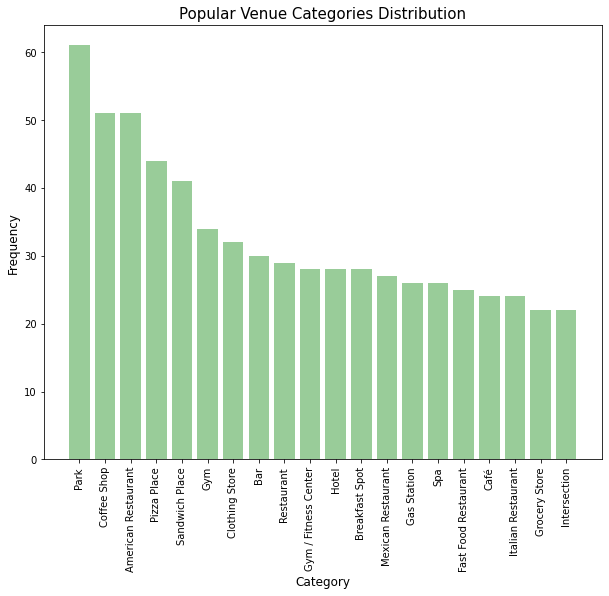

In [47]:
#Visualizing the top 20 categories
plt.figure(figsize=(10,8))
plt.bar(cat_top["Categories"],cat_top["Frequency"],alpha=0.4,color="green")
plt.title("Popular Venue Categories Distribution",size=15)
plt.xticks(rotation=90,size=10)
plt.yticks(size=10)
plt.xlabel("Category",size=12)
plt.ylabel("Frequency",size=12)
plt.show()


Next we can group the data by neighborhoods to see which ones consist of the highest number of venues, this would provide a good indication as to which neighborhoods might experience more traffic. 

### Group dataset by neighborhoods to see which neighborhoods have the highest density of venues

In [48]:
#Group by neighborhood
neighborhood_group = atlanta_venues.groupby("Neighborhood").apply(len)
neighborhood_group = neighborhood_group.sort_values(ascending=False)
print (neighborhood_group.head(30))

Neighborhood
Midtown                   100
Margaret Mitchell         100
Lenox                      80
Atlantic Station           73
Inman Park                 65
Wisteria Gardens           65
Buckhead Village           55
Buckhead Forest            55
West End                   44
Underwood Hills            44
Poncey-Highland            44
Grant Park                 42
Paces                      40
North Buckhead             40
Sweet Auburn               40
Cabbagetown                38
Virginia-Highland          36
Castleberry Hill           35
Lindbergh                  34
Garden Hills               30
Peachtree Park             28
Candler Park               26
Marietta Street Artery     24
Summerhill                 24
Berkeley Park              23
Brookwood                  23
West Highlands             22
Hills Park                 22
Kirkwood                   22
Springlake                 22
dtype: int64


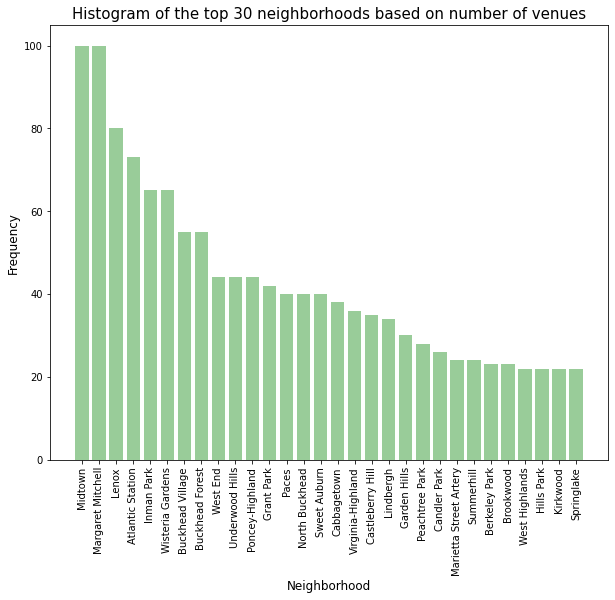

In [49]:
#Visualizing the top 20 categories
plt.figure(figsize=(10,8))
plt.bar(neighborhood_group.head(30).index,list(neighborhood_group.head(30)),alpha=0.4,color="green")
plt.title("Histogram of the top 30 neighborhoods based on number of venues",size=15)
plt.xticks(rotation=90,size=10)
plt.yticks(size=10)
plt.xlabel("Neighborhood",size=12)
plt.ylabel("Frequency",size=12)
plt.show()


From the histogram above, *Midtown, Peachtree Park and Margaret Mitchell* have the highest number of venues. 

The top 30 neighborhoods based on the number of venues has at least 20 venues in it's vicinity. Therefore, we can eliminate the rest of the neighborhoods from consideration as our goal is to look for areas of high traffic. 

In [50]:
#Retrieving the 83 neighborhoods with the lowest number of venues
bottom = list(neighborhood_group.tail(82).index)
len(bottom)

82

First, the *Neighborhood* column is set as the index which allows us to remove instances in the dataset that contain any of the *bottom 83* neighborhoods. 

In [51]:
#Dropping the bottom 83 neighborhoods
atlanta_venues_30 = atlanta_venues.set_index("Neighborhood")
atlanta_venues_30 = atlanta_venues_30.drop(bottom)
atlanta_venues_30 = atlanta_venues_30.reset_index()
print (atlanta_venues_30.head())

       Neighborhood  ...       Venue Category
0  Atlantic Station  ...  Monument / Landmark
1  Atlantic Station  ...          Pizza Place
2  Atlantic Station  ...       Shopping Plaza
3  Atlantic Station  ...        Big Box Store
4  Atlantic Station  ...       Ice Cream Shop

[5 rows x 10 columns]


The number of unique neighborhoods is printed to confirm that there are in fact 30 of them remaining. 

In [52]:
#Print the unique neighborhoods in the dataset
print ("Number of unique neighborhoods",len(atlanta_venues_30["Neighborhood"].unique()))

Number of unique neighborhoods 37


Before proceeding further, let's take another look at the neighborhoods using the *Folium* mapping library

In [53]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=11)

# add markers to map of Atlanta neighborhoods for the highest populated neighborhoods
for lat, lng, neighborhood in zip(atlanta_venues_30['Neighborhood Latitude'], atlanta_venues_30['Neighborhood Longitude'],atlanta_venues_30['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

After the previous round of filtering, we are now left with 30 neighborhoods which appear to be centrally located on the Atlanta map. Since these neighborhoods consist of the largest number of venues, this makes sense.

Let's take a look at the resulting dataframe. 

In [54]:
atlanta_venues_30.head()

Neighborhood  ...       Venue Category
0  Atlantic Station  ...  Monument / Landmark
1  Atlantic Station  ...          Pizza Place
2  Atlantic Station  ...       Shopping Plaza
3  Atlantic Station  ...        Big Box Store
4  Atlantic Station  ...       Ice Cream Shop

[5 rows x 10 columns]

In [55]:
atlanta_venues_30.shape

(1432, 10)

We are left with 159 venues in total spanning 30 neighborhoods. Let's check how many unique categories exist across the neighborhoods. 

In [56]:
#Unique venue categories
print ("There are",len(atlanta_venues_30["Venue Category"].unique()),"unique venue categories")

There are 232 unique venue categories


That's a lot of categories but we need to cluster the neighborhoods by preferably distinguishing between the high traffic and low traffic venues. 

Some of the high traffic venues that we are interested in are: 

- Restaurants
- Coffee shops
- Bars
- Parks
- Malls 
- Hotels

Secondly we also want to distinguish areas with venues that complement retail stores such as:

- Gas stations
- Parking lots
- Other clothing stores

First, we analyze the different venue categories by transforming the venues into a *sparse matrix* format. A **sparse matrix** is a matrix where each unique category (in this case) is set as a separate feature. If the category exists for that instance (neighborhood) in the dataframe, the entry is a *1* otherwise it's a *0*. 

So for example, if there are 8 unique categories, the sparse matrix would contain 8 columns (for each category) and rows equal to the number of observations (neighborhoods) in the original dataset. 

In [57]:
# one hot encoding
atlanta_onehot = pd.get_dummies(atlanta_venues_30[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
atlanta_onehot['Neighborhood'] = atlanta_venues_30['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [atlanta_onehot.columns[-1]] + list(atlanta_onehot.columns[:-1])
atlanta_onehot = atlanta_onehot[fixed_columns]

atlanta_onehot.head()

Zoo Exhibit  Accessories Store  ...  Yoga Studio  Zoo
0            0                  0  ...            0    0
1            0                  0  ...            0    0
2            0                  0  ...            0    0
3            0                  0  ...            0    0
4            0                  0  ...            0    0

[5 rows x 232 columns]

As we can see above, the sparse matrix mostly consists of 0 values. There are 255 columns which is the same as the number of unique categories as we discovered earlier. 

The next step would be find the highest occurring venues for each neighborhood. 

In [58]:
atlanta_onehot.shape

(1432, 232)

The sparse matrix consists of 1866 rows which equals the number of observations in our dataset. 

In [59]:
atlanta_grouped = atlanta_onehot.groupby('Neighborhood').mean().reset_index()
atlanta_grouped

Neighborhood  Zoo Exhibit  ...  Yoga Studio      Zoo
0         Atlantic Station     0.000000  ...     0.000000  0.00000
1            Berkeley Park     0.000000  ...     0.000000  0.00000
2                Brookwood     0.000000  ...     0.000000  0.00000
3          Brookwood Hills     0.000000  ...     0.000000  0.00000
4          Buckhead Forest     0.000000  ...     0.018182  0.00000
5         Buckhead Village     0.000000  ...     0.018182  0.00000
6              Cabbagetown     0.000000  ...     0.026316  0.00000
7             Candler Park     0.000000  ...     0.115385  0.00000
8      Cascade Avenue/Road     0.000000  ...     0.000000  0.00000
9         Castleberry Hill     0.000000  ...     0.000000  0.00000
10            Garden Hills     0.000000  ...     0.000000  0.00000
11              Grant Park     0.380952  ...     0.000000  0.02381
12         Heritage Valley     0.000000  ...     0.000000  0.00000
13              Hills Park     0.000000  ...     0.000000  0.00000
14              Inman Park     0.000000  ...     0.015385  0.00000
15                Kirkwood     0.000000  ...     0.000000  0.00000
16                   Lenox     0.000000  ...     0.000000  0.00000
17               Lindbergh     0.000000  ...     0.000000  0.00000
18       Margaret Mitchell     0.000000  ...     0.020000  0.00000
19  Marietta Street Artery     0.000000  ...     0.000000  0.00000
20                 Midtown     0.000000  ...     0.020000  0.00000
21          North Buckhead     0.000000  ...     0.000000  0.00000
22                   Paces     0.000000  ...     0.000000  0.00000
23          Peachtree Park     0.000000  ...     0.000000  0.00000
24        Piedmont Heights     0.000000  ...     0.000000  0.00000
25              Pine Hills     0.000000  ...     0.000000  0.00000
26         Poncey-Highland     0.000000  ...     0.045455  0.00000
27            Reynoldstown     0.000000  ...     0.000000  0.00000
28          Ridgedale Park     0.000000  ...     0.000000  0.00000
29              Springlake     0.000000  ...     0.000000  0.00000
30              Summerhill     0.000000  ...     0.000000  0.00000
31            Sweet Auburn     0.000000  ...     0.000000  0.00000
32         Underwood Hills     0.000000  ...     0.000000  0.00000
33       Virginia-Highland     0.000000  ...     0.027778  0.00000
34                West End     0.000000  ...     0.000000  0.00000
35          West Highlands     0.000000  ...     0.000000  0.00000
36        Wisteria Gardens     0.000000  ...     0.000000  0.00000

[37 rows x 232 columns]

In [60]:
atlanta_grouped.shape

(37, 232)

We now have a dataset grouped by neighborhoods which also shows the frequecy of each venue in the dataset for that neighborhood. From this data, we can determine the most common venues for each neighborhood. We can pick the 10 most common venues for each neighborhood. 

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [62]:
#Dropping all venue related columns from the dataset 
neighborhoods_30_list = list(atlanta_venues_30["Neighborhood"].unique())
neighborhoods_all_list = df["Neighborhood"].unique()
neighborhoods_list = []

for i in neighborhoods_all_list:
    if i not in neighborhoods_30_list:
        neighborhoods_list.append(i)

df_atlanta = df
df_atlanta = df_atlanta.set_index("Neighborhood")
df_atlanta = df_atlanta.drop(neighborhoods_list)
df_atlanta = df_atlanta.reset_index()
df_atlanta.head()

Neighborhood  Population NPU   Latitude  Longitude  Distance
0  Atlantic Station        1888   E  33.790061 -84.398518  0.042387
1     Berkeley Park        1400   D  33.801056 -84.409492  0.056318
2         Brookwood        1834   E  33.802605 -84.392983  0.053836
3   Brookwood Hills        2103   E  33.807883 -84.390205  0.058924
4   Buckhead Forest        2252   B  33.839814 -84.379559  0.091205

In [63]:
df_atlanta.shape

(37, 6)

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = atlanta_grouped['Neighborhood']

for ind in np.arange(atlanta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(atlanta_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood  ...   10th Most Common Venue
0  Atlantic Station  ...                  Dog Run
1     Berkeley Park  ...          Coworking Space
2         Brookwood  ...  New American Restaurant
3   Brookwood Hills  ...               Taco Place
4   Buckhead Forest  ...                Juice Bar

[5 rows x 11 columns]

In [65]:
neighborhoods_venues_sorted["Population"] = df_atlanta["Population"]
neighborhoods_venues_sorted["Distance"] = df_atlanta["Distance"]
neighborhoods_venues_sorted.head()

Neighborhood    1st Most Common Venue  ... Population  Distance
0  Atlantic Station           Clothing Store  ...       1888  0.042387
1     Berkeley Park         Department Store  ...       1400  0.056318
2         Brookwood       Mexican Restaurant  ...       1834  0.053836
3   Brookwood Hills  New American Restaurant  ...       2103  0.058924
4   Buckhead Forest               Restaurant  ...       2252  0.091205

[5 rows x 13 columns]

## Clustering

Using *k-means* to cluster the neighborhoods based on **venue categories** and **neighborhood population**

In [66]:
# set number of clusters
kclusters = 5

atlanta_grouped_clustering = atlanta_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(atlanta_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 1, 0, 0, 2, 2, 2, 2], dtype=int32)

In [67]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

atlanta_merged = df_atlanta.drop(["Population","Distance"],axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
atlanta_merged = atlanta_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

atlanta_merged.head() # check the last columns!

Neighborhood NPU  ...  Population  Distance
0  Atlantic Station   E  ...        1888  0.042387
1     Berkeley Park   D  ...        1400  0.056318
2         Brookwood   E  ...        1834  0.053836
3   Brookwood Hills   E  ...        2103  0.058924
4   Buckhead Forest   B  ...        2252  0.091205

[5 rows x 17 columns]

In [68]:
atlanta_merged.shape

(37, 17)

### Visualizing clusters

In [69]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atlanta_merged['Latitude'], atlanta_merged['Longitude'], atlanta_merged['Neighborhood'], atlanta_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the map, you can see that that there is a somewhat distinguishable pattern between the clusters. Noticeably, the **purple** and **orange** clusters are the largest and are localized, to a great extent, around the same area. There appears to be 3 purple neighborhoods that are away from the main cluster but most of the blue neighborhoods are close together. 

The **light green** and **light blue** clusters appear to be relatively small and are located at the periphery of all the clusters. 

In [70]:
#Dropping the Distance column
atlanta_merged = atlanta_merged.drop(["NPU","Longitude","Latitude","Distance"],axis=1)

In [71]:
#Moving the position of the Population column
atlanta_clusters = pd.DataFrame()
atlanta_clusters["Neighborhood"] = atlanta_merged["Neighborhood"]
atlanta_clusters["Population"] = atlanta_merged["Population"]
atlanta_clusters = atlanta_clusters.join(atlanta_merged.drop(["Population","Neighborhood"],axis=1))
atlanta_clusters.head()

Neighborhood  Population  ...  9th Most Common Venue   10th Most Common Venue
0  Atlantic Station        1888  ...               Boutique                  Dog Run
1     Berkeley Park        1400  ...         Cosmetics Shop          Coworking Space
2         Brookwood        1834  ...            Coffee Shop  New American Restaurant
3   Brookwood Hills        2103  ...                    Bar               Taco Place
4   Buckhead Forest        2252  ...              Gastropub                Juice Bar

[5 rows x 13 columns]

## Examine clusters

In [72]:
atlanta_merged["Cluster Labels"].unique()

array([0, 1, 2, 3, 4], dtype=int32)

### Cluster 0

In [73]:
atlanta_merged[atlanta_merged["Cluster Labels"]==0]

Neighborhood  ...  Population
0         Atlantic Station  ...        1888
1            Berkeley Park  ...        1400
2                Brookwood  ...        1834
4          Buckhead Forest  ...        2252
5         Buckhead Village  ...        1343
10            Garden Hills  ...        3939
16                   Lenox  ...        1663
17               Lindbergh  ...        4598
18       Margaret Mitchell  ...        1207
19  Marietta Street Artery  ...         745
20                 Midtown  ...       16569
21          North Buckhead  ...        8270
22                   Paces  ...        2623
23          Peachtree Park  ...        1316
24        Piedmont Heights  ...        2323
26         Poncey-Highland  ...        2133
29              Springlake  ...        1031
31            Sweet Auburn  ...        1882
32         Underwood Hills  ...        3410
33       Virginia-Highland  ...        7800
34                West End  ...        4270
35          West Highlands  ...        1164
36        Wisteria Gardens  ...         512

[23 rows x 13 columns]

### Cluster 1

In [74]:
atlanta_merged[atlanta_merged["Cluster Labels"]==1]

Neighborhood  Cluster Labels  ... 10th Most Common Venue Population
3   Brookwood Hills               1  ...             Taco Place       2103
12  Heritage Valley               1  ...        Thai Restaurant        910
25       Pine Hills               1  ...             Taco Place       8033

[3 rows x 13 columns]

### Cluster 2

In [75]:
atlanta_merged[atlanta_merged["Cluster Labels"]==2]

Neighborhood  Cluster Labels  ... 10th Most Common Venue Population
6           Cabbagetown               2  ...             Taco Place       1247
7          Candler Park               2  ...            Bridal Shop       3291
8   Cascade Avenue/Road               2  ...             Shoe Store       2416
9      Castleberry Hill               2  ...               Boutique       1285
13           Hills Park               2  ...            Music Venue        953
14           Inman Park               2  ...           Dessert Shop       4098
15             Kirkwood               2  ...             Sports Bar       5897
27         Reynoldstown               2  ...         Farmers Market       2550
28       Ridgedale Park               2  ...     Mexican Restaurant       1685

[9 rows x 13 columns]

### Cluster 3

In [76]:
atlanta_merged[atlanta_merged["Cluster Labels"]==3]

Neighborhood  Cluster Labels  ... 10th Most Common Venue Population
11   Grant Park               3  ...   Gym / Fitness Center       6771

[1 rows x 13 columns]

### Cluster 4

In [77]:
atlanta_merged[atlanta_merged["Cluster Labels"]==4]

Neighborhood  Cluster Labels  ... 10th Most Common Venue Population
30   Summerhill               4  ...                 Bakery       2025

[1 rows x 13 columns]

Looking at the clusters above, there are some distinguishable patterns but overall it looks like the two biggest clusters 1 and 4 look more promising as they cover a whole range of venue categories and also contain important ones that we had considered earlier. 

Let's quickly check what the population distribution looks like between each cluster. 

In [78]:
#Find the number of venues for each cluster
cluster_sizes = list(atlanta_merged.groupby("Cluster Labels").count()["Neighborhood"])

#Finding the average population for each cluster
cluster_pop = list(atlanta_merged.groupby("Cluster Labels").mean()["Population"])

#Creating a dataframe to store the cluster information
atlanta_clusters = pd.DataFrame()
atlanta_clusters["Cluster"] = atlanta_merged.groupby("Cluster Labels").count().index
atlanta_clusters["Number of neighborhoods"] = cluster_sizes
atlanta_clusters["Average population"] = cluster_pop
atlanta_clusters

Cluster  Number of neighborhoods  Average population
0        0                       23         3224.869565
1        1                        3         3682.000000
2        2                        9         2602.444444
3        3                        1         6771.000000
4        4                        1         2025.000000

Note that cluster 3 only contains one neighborhood with a relatively large population of *6771*. Therefore, the statistics above is a bit misleading. To get a better idea of the population distribution we therefore look at the other 4 clusters. 

- Clusters 1 and 4, however, seem to have the most important venues

- Clusters 1 and 4 are also the two largest clusters

To summarise here are the three main aspects that point towards clusters 1 and 4 as being more favorable options: 

1. They are the largest clusters on the map and are mostly centralized to one area. The 2 clusters **can be separated into somehwat distinguishable areas**. Also, these 2 clusters are located right in the heart of Atlanta as seen on the map. The neighborhoods are **concentrated at the center of the I-285 circe**. 

2. Looking at the cluster tables above, clusters 1 and 4 not only **contain majority of the neighborhoods** but also contain a **good mix of the important venues** that we are interested in, which could help maximize traffic to our new retail store. 

3. From the population distribution above, clusters 1 and 4 also have a **relatively high average population**. This is considering that clusters 2 and 3 just have 2 and 1 neighborhoods respectively, with venues that are not as important, hence we ignore them from the population consideration. 

Between clusters 1 and 4, it's worth exploring cluster 4 a little bit more since: 
- It has a higher average population
- It appears to have a better mix of different types of venues

### Examining cluster 4

In [79]:
cluster_4 = atlanta_merged[atlanta_merged["Cluster Labels"]==4]
cluster_4

Neighborhood  Cluster Labels  ... 10th Most Common Venue Population
30   Summerhill               4  ...                 Bakery       2025

[1 rows x 13 columns]

In [80]:
#Getting all venues for cluster 4
venues_4 = []
for i in range(2,12):
    venues_4.extend(cluster_4.iloc[:,i])
    
len(venues_4)

10

In [81]:
venues_4_freq = Counter(venues_4)

categories_freq_4 = pd.DataFrame()
categories_freq_4["cluster 4 venues"] = venues_4_freq.keys()
categories_freq_4["cluster 4 frequency"] = venues_4_freq.values()
categories_freq_4 = categories_freq_4.sort_values("cluster 4 frequency",ascending=False)
categories_freq_4.index = range(categories_freq_4.shape[0])

print (categories_freq_4)

        cluster 4 venues  cluster 4 frequency
0         Baseball Field                    1
1                   Park                    1
2              BBQ Joint                    1
3                 Circus                    1
4  Outdoors & Recreation                    1
5           Liquor Store                    1
6                Parking                    1
7             Restaurant                    1
8                  Track                    1
9                 Bakery                    1


In [82]:
categories_freq_4.head(20)["cluster 4 venues"]

0           Baseball Field
1                     Park
2                BBQ Joint
3                   Circus
4    Outdoors & Recreation
5             Liquor Store
6                  Parking
7               Restaurant
8                    Track
9                   Bakery
Name: cluster 4 venues, dtype: object

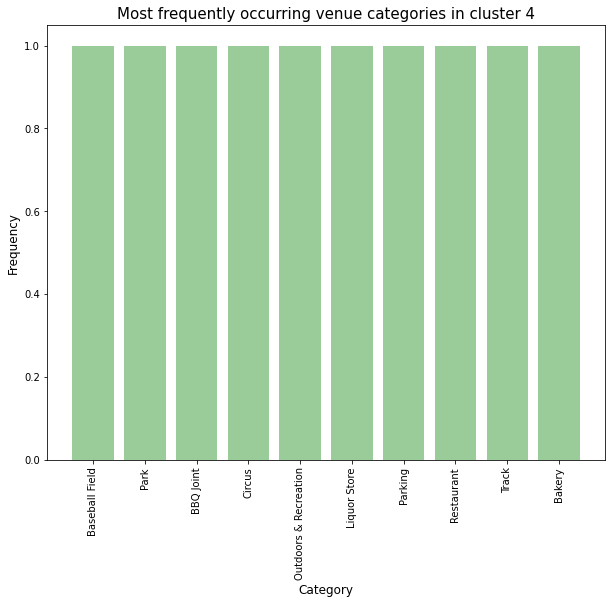

In [83]:
#Visualizing the top 20 categories
plt.figure(figsize=(10,8))
plt.bar(categories_freq_4.head(20)["cluster 4 venues"],categories_freq_4.head(20)["cluster 4 frequency"],alpha=0.4,color="green")
plt.title("Most frequently occurring venue categories in cluster 4",size=15)
plt.xticks(rotation=90,size=10)
plt.yticks(size=10)
plt.xlabel("Category",size=12)
plt.ylabel("Frequency",size=12)
plt.show()

The most common venues for **cluster 4** are coffee shops, restaurants, bars and pizza places. That is followed by taco places, history museums, american restaurants, dessert shops, grocery stores and barber shops. Some of the less common important venues include historic sites, steakhouses, gas stations, music venues, yoga studios and gastropubs. 

*Cluster 4* appears to be promising as it not only contains more venues in genenal but also contains more "important" venues which we are looking for. Also venues such as yoga studios, grocery stores and barber shops incidate that there will likely be more regular customers returning to these places.  

In [84]:
cluster_4

Neighborhood  Cluster Labels  ... 10th Most Common Venue Population
30   Summerhill               4  ...                 Bakery       2025

[1 rows x 13 columns]

Narrowing down the cluster to only those neighborhoods with population of over 4000. Since we are looking for high traffic areas, a higher population will ensure that on average an area sees more people. 

In [85]:
#Selecting neighborhoods with population greater than 4000
final_neighborhoods = cluster_4[cluster_4["Population"]>4000]
final_neighborhoods

Empty DataFrame
Columns: [Neighborhood, Cluster Labels, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue, Population]
Index: []

Most of the above neighborhoods contain restaurants, gas stations, bars and coffee shops, three venues that attract large crowds. However, Inman Park does not appear to have bars as one of the most common venues whereas North Buckhead lacks gas stations. Hence, we are left with Virginia-Highland which not only contains all the important venues but also has a good mix part of it's most common venues. 

From the table above, **Virginia Highlands** appears to be the most promising neighborhood for our new retail store. Here are the key reasons why: 

- Virginia Highlands has a population of 7800 which is substantially higher than the upper quartile of the population distribution across the neighborhoods. A higher population ensures higher rate of traffic in the neighborhood. The presence of restaurants, furniture stores and shop & service venues suggests that this area could have a good amount of residents who are likely to flock to these venues. 
- The neighborhood contains a lot of the important venues that we had mentioned earlier - *clothing stores*, *boutique stores*, *bars*,*gas station*,*cafes* and *restaurants*. This also suggests that tourists could be attracted to the area who are often likely to visit retail stores. 
- It is in close proximity to another neighborhood in the same cluster - **Druid Hill**. Although this neighborhood consists of similar venues, this provides customers/tourists with more options. **Poncey-Highland** and **Wisteria Gardens** are also relatively close to Virginia Highlands and are in close proximity to one another as well. They consist of museums, music stores/venues and vintage stores which are not there in either Virginia-Highlands or Druid Hills. 